In [1]:
%matplotlib inline
import tqdm
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import torch
from torch import tensor
from torchvision import transforms, datasets

data_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize(mean=[0],std=[1])])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

# Initialize the counters
xcount = torch.ones((784,10), dtype=torch.float32)
ycount = torch.ones((10), dtype=torch.float32)

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

# using broadcast again for division
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1,10))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

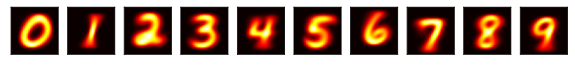

Class probabilities tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [3]:

import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).numpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)

plt.show()
print('Class probabilities', py)

In [4]:
data, label = mnist_test[0]
data = data.reshape((784,1))

# Compute the per pixel conditional probabilities
xprob = (px * data + (1-px) * (1-data))

xprob = xprob.prod(0) * py
print('Unnormalized Probabilities', xprob)
# Normalization
xprob = xprob / xprob.sum()
print('Normalized Probabilities', xprob)

Unnormalized Probabilities tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Normalized Probabilities tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


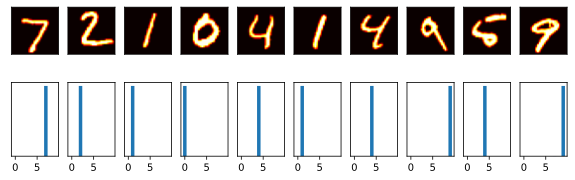

In [6]:
logpx = torch.log(px)
logpxneg = torch.log(1-px)
logpy = torch.log(py)

def bayespost(data):
    logpost = logpy.clone()
    logpost += (logpx * data + logpxneg * (1-data)).sum(0)
    
    logpost -= torch.max(logpost)

    post = torch.exp(logpost).numpy()
    post /= np.sum(post)
    return post

fig, figarr = plt.subplots(2, 10, figsize=(10, 3))

# 10 images
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)

    # Bar chart and image of digit
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).numpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1

    if ctr == 10:
        break

plt.show()

In [7]:
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)


Naive Bayes has an error rate of 0.1553
